# Height Mapping from Normal Mapping with Averaged Integrals from Rotated Discrete Origin Functions

This algorithm estimates a 3d integral with the normal mapping. First the directional gradients of the normals in x- and y-direction are calculated. They are then used to calculate the integrated values by a cumulative sum (Riemann sum). This process is repeated with differently rotated versions of the gradient mapping to average the values and reduce errors as a cumulative sum alone is very prone for subsequent errors.

## Imports


In [1]:
import numpy as np
import cv2 as cv
from skimage import io
from matplotlib import pyplot as plt
from scipy.ndimage import rotate
from math import sin, cos, radians, sqrt, ceil, floor
from os import cpu_count
from threading import Thread
from typing import List, Tuple
from logging import warning


## Declarations


In [2]:
NORMAL_IS_OPEN_GL: bool = True  # @param {type: "boolean"}
NORMAL_IS_PSEUDO_COMPRESSED: bool = False  # @param {type: "boolean"}
TARGET_ITERATION_COUNT: int = 500  # @param {type: "slider", min: 1, max: 1000}

IS_NOTEBOOK: bool = True  # @param {type: "boolean"}
NORMAL_MAP_FILE_NAME: str = "normal.png"  # @param {type: "string"}
OPACITY_MAP_FILE_NAME: str = "opacity.png"  # @param {type: "string"}
HEIGHT_MAP_FILE_NAME: str = "height.png"  # @param {type: "string"}

PATH_PREFIX: str = (
    "https://raw.githubusercontent.com/YertleTurtleGit/photometric-stereo-mappings/main/test_dataset/output/"
    if IS_NOTEBOOK
    else "./../test_dataset/output/"
)

NORMAL_MAP_PATH: str = PATH_PREFIX + NORMAL_MAP_FILE_NAME
OPACITY_PATH: str = PATH_PREFIX + OPACITY_MAP_FILE_NAME
OUTPUT_PATH = None if IS_NOTEBOOK else PATH_PREFIX + HEIGHT_MAP_FILE_NAME

MAX_THREAD_COUNT: int = max(int(cpu_count() or 1), 1)


In [3]:
if IS_NOTEBOOK:
    from IPython.display import HTML, display

    def progress(value: float, max: float = 100) -> HTML:
        return HTML(
            """
            <progress
                value='{value}'
                max='{max}',
                style='width: 100%'
            >{value}</progress>
            """.format(
                value=value, max=max
            )
        )


In [4]:
def _read_image(
    image_path: str, color: bool = True, target_dtype: np.dtype = np.dtype("float64")
) -> np.ndarray:
    """Reads an image from URI and converts it to an array with specified bit depth.

    Args:
        image_path (str): The path to the image file.
        color (bool, optional): Read image as color image. Defaults to True.
        target_dtype (np.dtype, optional): The target bit depth. Defaults to np.dtype("float64").

    Returns:
        np.ndarray: The output array with shape (w,h,3) for color or (w,h) for grayscale images.
    """
    image = io.imread(image_path)
    image_dtype: np.dtype = image.dtype
    image = image.astype(target_dtype)

    if image_dtype == np.dtype("uint8"):
        image /= pow(2, 8) - 1
    elif image_dtype == np.dtype("uint16"):
        image /= pow(2, 16) - 1
    elif image_dtype == np.dtype("uint32"):
        image /= pow(2, 32) - 1

    if color:
        if len(image.shape) == 3:
            return image
        elif len(image.shape) == 2:
            return np.array([image, image, image])
        elif len(image.shape) == 4:
            return np.array([image[:, :, 0], image[:, :, 1], image[:, :, 2]])
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )
    else:
        if len(image.shape) == 2:
            return image
        elif len(image.shape) == 3 or len(image.shape) == 4:
            return (image[:, :, 0] + image[:, :, 1] + image[:, :, 2]) / 3
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )

    return image


## Logic


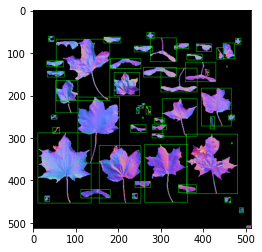

In [5]:
def _get_atlas_countries(
    mask: np.ndarray, albedo: np.ndarray
) -> Tuple[List[np.ndarray], List[Tuple[int, int, int, int]]]:

    image_parts: List[np.ndarray] = []
    image_parts_rectangles: List[Tuple[int, int, int, int]] = []

    for x in range(0, mask.shape[0]):
        for y in range(0, mask.shape[1]):
            if mask[x, y] > 0:
                mask_before = mask.copy()
                _, mask, _, rect = cv.floodFill(np.float32(mask), None, (y, x), 0)

                part_albedo = albedo.copy()
                part_albedo[mask_before == mask] = 0

                r_y, r_x, r_h, r_w = rect
                image_part = part_albedo[r_x : r_x + r_w, r_y : r_y + r_h]

                image_parts.append(image_part)
                image_parts_rectangles.append((r_x, r_y, r_w, r_h))

    return image_parts, image_parts_rectangles


if IS_NOTEBOOK:
    atlas = _read_image(OPACITY_PATH, color=False)
    albedo = _read_image(NORMAL_MAP_PATH)

    _, rectangles = _get_atlas_countries(atlas, albedo)
    for rectangle in rectangles:
        albedo = cv.rectangle(
            albedo,
            (rectangle[1], rectangle[0]),
            (rectangle[1] + rectangle[3], rectangle[0] + rectangle[2]),
            (0, 1, 0),
            round(min(atlas.shape[0], atlas.shape[1]) * 0.0025),
        )
    plt.imshow(albedo)


$
\displaystyle
\int f(x,y) \approx \sum_{\theta = 0}^{2\pi} \sum_{x=0}^{x_{max}} f(x,y) R_{\theta}, \text{ where } x,y \in \mathbb{N} \text{ and } \theta \in [ 0, 2\pi ] \cap \mathbb{R}
$

In [6]:
def _integrate(
    normal_map: np.ndarray,
    normal_is_open_gl: bool,
    normal_is_pseudo_compressed: bool,
    target_iteration_count: int,
    max_thread_count: int,
) -> np.ndarray:

    if normal_is_pseudo_compressed:
        # TODO Fix line.
        normal_map[:, :2] *= 2
        normal_map[:, :2] -= 1

    # TODO Handle non-open_gl.

    SLOPE_SHIFT: float = -0.5
    normal_map[:, :, 0][normal_map[:, :, 2] != 0] /= normal_map[:, :, 2][
        normal_map[:, :, 2] != 0
    ]
    normal_map[:, :, 1][normal_map[:, :, 2] != 0] /= normal_map[:, :, 2][
        normal_map[:, :, 2] != 0
    ]
    normal_map[normal_map[:, :, 2] == 0] = [0, 0, 0]
    normal_map[normal_map[:, :, 2] != 0] += SLOPE_SHIFT
    normal_map[:, :, 0] *= -1

    n_w, n_h, _ = normal_map.shape

    diagonal_length: int = ceil(sqrt(pow(n_w, 2) + pow(n_h, 2)))
    isotropic_integral = np.zeros((diagonal_length, diagonal_length))

    i_w, i_h = isotropic_integral.shape

    fx: np.ndarray = np.zeros(isotropic_integral.shape)
    fy: np.ndarray = np.zeros(isotropic_integral.shape)

    fx[
        floor((i_w - n_w) / 2) : floor((i_w + n_w) / 2),
        floor((i_h - n_h) / 2) : floor((i_h + n_h) / 2),
    ] = normal_map[:, :, 0]
    fy[
        floor((i_w - n_w) / 2) : floor((i_w + n_w) / 2),
        floor((i_h - n_h) / 2) : floor((i_h + n_h) / 2),
    ] = normal_map[:, :, 1]

    def integrate_anisotropic(angles: List[float]):
        for angle in angles:
            x_factor: float = cos(radians(angle))
            y_factor: float = sin(radians(angle))

            factor_norm: float = abs(x_factor) + abs(y_factor)
            x_factor /= factor_norm
            y_factor /= factor_norm

            fxy = fx * x_factor + fy * y_factor
            fxy = rotate(fxy, angle, axes=(1, 0), reshape=False)

            anisotropic_integral = rotate(
                np.cumsum(fxy, axis=1), -angle, axes=(1, 0), reshape=False
            )
            isotropic_integral[~np.isnan(anisotropic_integral)] += anisotropic_integral[
                ~np.isnan(anisotropic_integral)
            ]

    anisotropic_integral_threads: List[Thread] = []
    angle_per_thread: float = 360 / max_thread_count
    iterations_per_thread: int = round(target_iteration_count / max_thread_count)

    for thread_id in range(0, max_thread_count):
        angles = np.linspace(
            thread_id * angle_per_thread,
            (thread_id + 1) * angle_per_thread,
            iterations_per_thread,
            endpoint=False,
        )
        thread = Thread(target=integrate_anisotropic, args=(angles,))
        thread.start()
        anisotropic_integral_threads.append(thread)

    for thread in anisotropic_integral_threads:
        thread.join()

    height_map = isotropic_integral[
        floor((i_w - n_w) / 2) : floor((i_w + n_w) / 2),
        floor((i_h - n_h) / 2) : floor((i_h + n_h) / 2),
    ]

    height_map[
        np.sqrt(
            np.abs(normal_map[:, :, 0])
            + np.abs(normal_map[:, :, 1])
            + np.abs(normal_map[:, :, 2])
        )
        == 0
    ] = None

    return height_map


In [7]:
def height_map(
    normal_map_path: str,
    opacity_path: str,
    output_path: str = None,
    normal_is_open_gl: bool = True,
    normal_is_pseudo_compressed: bool = False,
    target_iteration_count: int = 250,
    max_thread_count: int = max(int(cpu_count() or 1), 1),
) -> np.ndarray:
    normal_map = _read_image(normal_map_path)
    mask = _read_image(opacity_path, color=False)
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1

    countries, country_bounding_boxes = _get_atlas_countries(mask, normal_map)

    height_map = np.zeros((normal_map.shape[0], normal_map.shape[1]))

    if IS_NOTEBOOK:
        progress_bar: DisplayHandle = display(progress(0), display_id=True)

    for i in range(0, len(countries)):
        p_x, p_y, p_w, p_h = country_bounding_boxes[i]
        part_height_map = _integrate(
            countries[i],
            normal_is_open_gl,
            normal_is_pseudo_compressed,
            target_iteration_count,
            max_thread_count,
        )
        height_map[p_x : p_x + p_w, p_y : p_y + p_h][
            ~np.isnan(part_height_map)
        ] = part_height_map[~np.isnan(part_height_map)]

        percent: float = (i / len(countries)) * 100

        if IS_NOTEBOOK:
            # TODO Progress for non-atlas images.
            progress_bar.update(progress(percent))
        else:
            print(str(percent) + "%")

    height_map -= np.min(height_map)
    height_map /= np.max(height_map)
    height_map *= pow(2, 8) - 1

    height_map[mask == 0] = 0

    if output_path:
        cv.imwrite(output_path, height_map)
    else:
        plt.imshow(height_map)

    if IS_NOTEBOOK:
        progress_bar.update("")

    return height_map


## Example usage

''

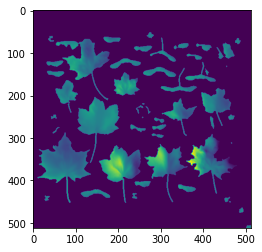

In [8]:
if __name__ == "__main__":
    height_map(
        NORMAL_MAP_PATH,
        OPACITY_PATH,
        OUTPUT_PATH,
        NORMAL_IS_OPEN_GL,
        NORMAL_IS_PSEUDO_COMPRESSED,
        TARGET_ITERATION_COUNT,
        MAX_THREAD_COUNT,
    )
